In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#from statsmodels.discrete.discrete_model import Logit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
print('-' * 80)
print('train')
df = import_data('../input/heart.csv')
#df = pd.read_csv("../input/heart.csv")

--------------------------------------------------------------------------------
train
Memory usage of dataframe is 0.03 MB
Memory usage after optimization is: 0.01 MB
Decreased by 83.7%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int8
sex         303 non-null int8
cp          303 non-null int8
trestbps    303 non-null int16
chol        303 non-null int16
fbs         303 non-null int8
restecg     303 non-null int8
thalach     303 non-null int16
exang       303 non-null int8
oldpeak     303 non-null float16
slope       303 non-null int8
ca          303 non-null int8
thal        303 non-null int8
target      303 non-null int8
dtypes: float16(1), int16(3), int8(10)
memory usage: 5.4 KB


In [5]:
df.apply(lambda x: sum(x.isnull()))

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.300781,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.400391,2,0,2,1


In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.040039,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161133,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.799805,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.599609,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.199219,2.000000,4.000000,3.000000,1.000000


All right, there is no data missing at all. We've got 303 observations in which 54,45% people had heart diseases. At first glance I would say that not every variable should be continuous but rather categorical.

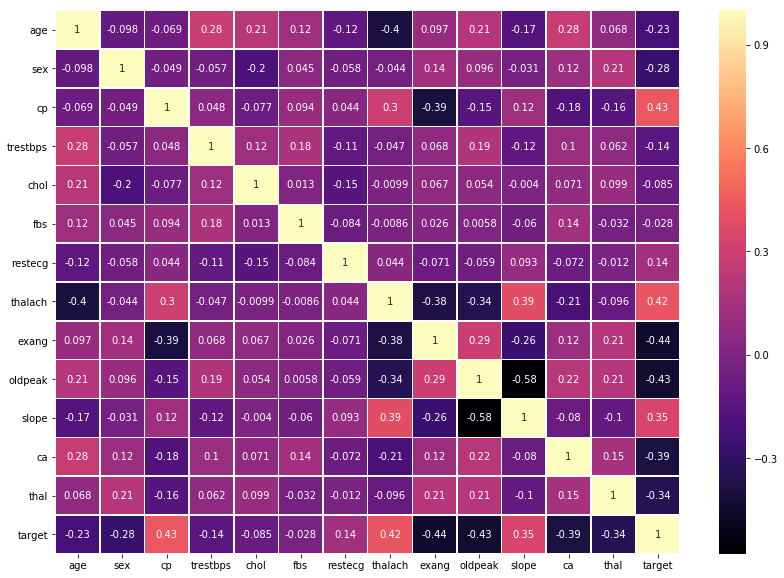

In [8]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, linewidths=0.5, cmap='magma')

Reading the data description I decided to change those variables which look like category data. Right now I can't say if that is correct because I'm not too much into medicine and do not know how exactly those variables affect the heart diseases.

In [9]:
# 2 categories
df['sex'] = df['sex'].replace({1: 'male',
                              0: 'female'})
df['exang'] = df['exang'].replace({1: 'yes',
                                 0: 'no'})
df['fbs'] = df['fbs'].replace({1: 'over 120',
                              0: 'under 120'})
# more than 2 categories
df['cp_cat'] = df['cp'].replace({0: '1st type',
                            1: '2st type',
                            2: '3st type',
                            3: '4st type'})

df['restecg_cat'] = df['restecg'].replace({0: 'normal',
                                      1: 'ST-T wave abnormality',
                                      2: 'left ventricular hypertrophy'})
df['slope_cat'] = df['slope'].replace({0: 'upsloping',
                                  1: 'flat',
                                  2: 'downsloping'})
#df['target'] = df['target'].replace({0: 'no', 1: 'yes'})
# category
df['ca_cat'] = df['ca'].astype('category')
df['thal_cat'] = df['thal'].astype('category')
df['sex'] = df['sex'].astype('category')
df['cp_cat'] = df['cp_cat'].astype('category')
df['fbs'] = df['fbs'].astype('category')
df['restecg_cat'] = df['restecg_cat'].astype('category')
df['exang'] = df['exang'].astype('category')
df['slope_cat'] = df['slope_cat'].astype('category')


In [10]:
old_columns = ['cp', 'restecg', 'slope', 'ca', 'thal']

In [11]:
def bar_plot(columns):
    v = df[columns][df['target'] == 1].value_counts(normalize=True)
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
    sns.barplot(x=v.index, y=v.values, ax=ax1, palette='Set1')
    ax1.set_ylim(0,1)
    sns.countplot(x=df[columns], ax=ax2, palette='Set1')
    plt.suptitle('Category Column: {}'.format(columns), size=20)

In [12]:
def category_plot(column, order=None):
    v = df[column].value_counts(normalize=True)
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))
    #1
    sns.countplot(x=column, data=df, order=order, label='Whole population',
                  color='blue', ax=ax1)
    sns.countplot(x=column, data=df[df['target'] == 1], order=order,
                  label='Participation of 1 target population', color='red', ax=ax1)
    #2
    sns.barplot(x=v.index, y=v.values, ax=ax2, palette='Set1', order=order)
    ax1.tick_params(rotation=60)
    ax2.tick_params(rotation=60)
    ax2.set_ylim(0,1)
    ax1.legend(loc='best')
    ax1.set_xlabel('')
    ax1.set_title('Appearance of heart diseases')
    ax2.set_title('Distribution of category')
    plt.suptitle('Category column: {}'.format(column))
    plt.show()

**Visualization of categorical data**

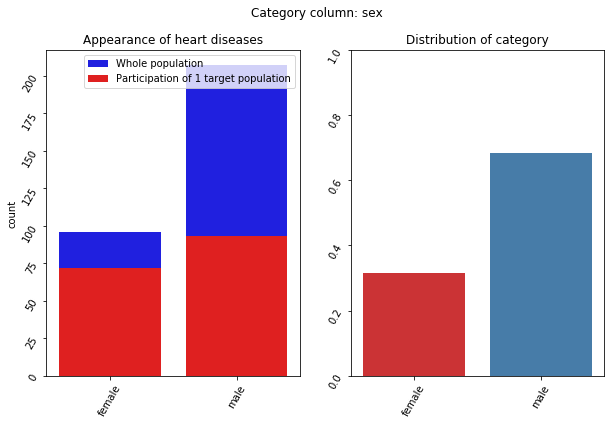

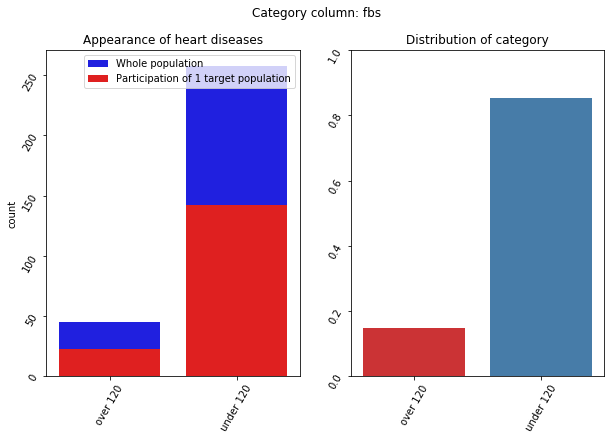

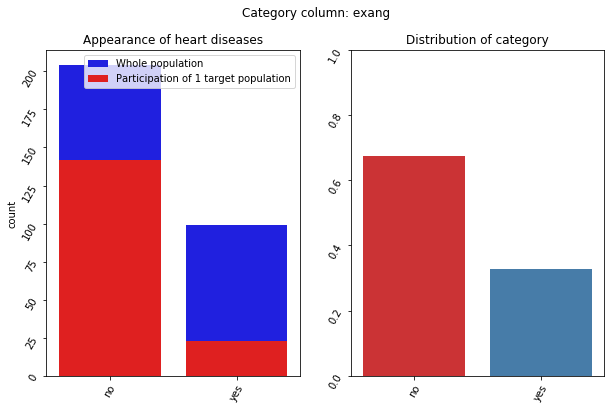

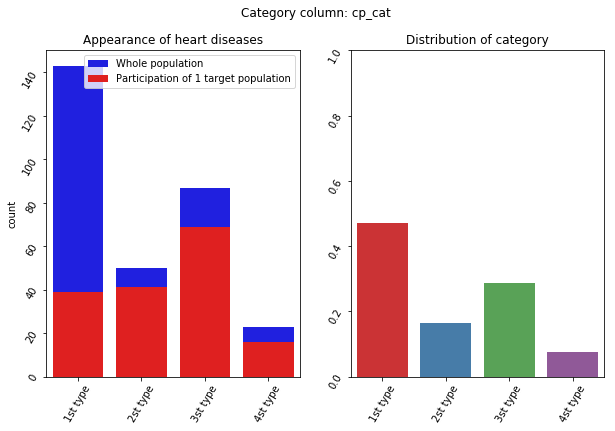

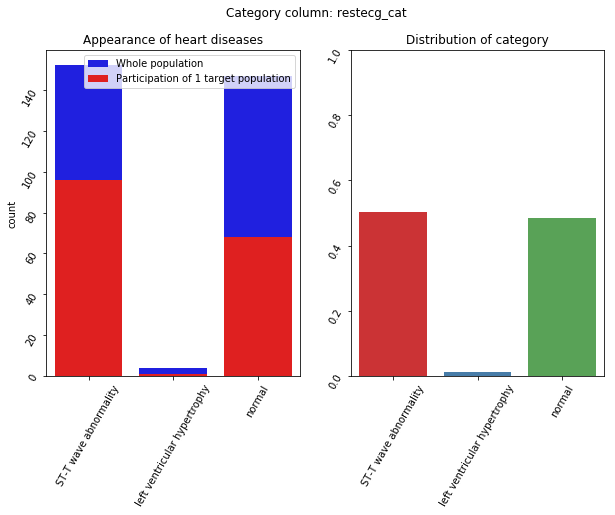

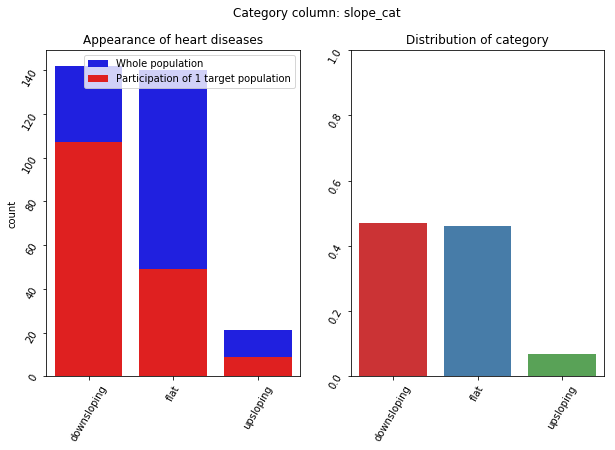

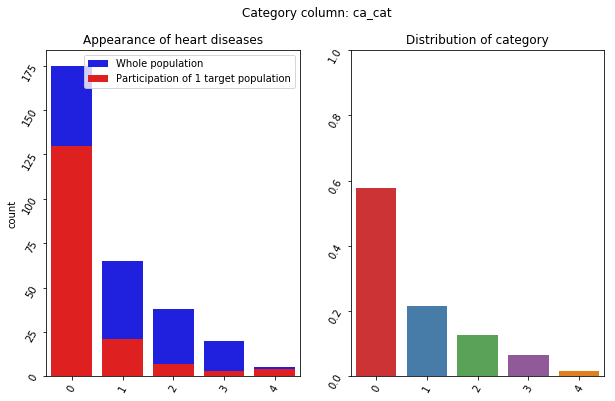

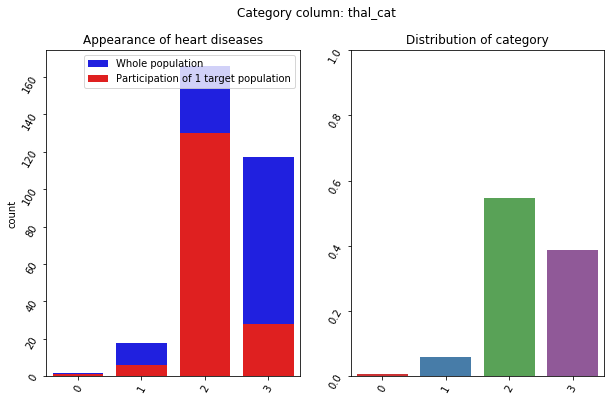

In [13]:
cat_col = df.select_dtypes(include='category')
for c in cat_col:
    category_plot(c)

**Visualization of numerical data**

In [14]:
num_cols = df.select_dtypes(include='number').columns
num_cols = [c for c in num_cols if c in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]

In [15]:
def plot_hist(column):
    plt.figure(figsize=(14,10))
    plt.hist(df[column], bins=20, edgecolor='black', label='Whole group', color='black')
    plt.hist(df[column][df['target'] == 1], bins=20, color='red', edgecolor='black', histtype='stepfilled', alpha=0.8,label='1 target group')
    plt.hist(df[column][df['target'] == 0], bins=20, color='yellow', edgecolor='black', histtype='stepfilled', alpha=0.8,label='0 target group')
    plt.title('Histogram of {}'.format(column))
    plt.legend()
    skeww = round(skew(df[column]),4)
    #plt.text(65, 25, s='Skewness: {}'.format(skeww), size=12)
    print('Skewness:',column, round(skew(df[column]),4))

Skewness: age -0.2015
Skewness: trestbps 0.7102
Skewness: chol 1.1377
Skewness: thalach -0.5347
Skewness: oldpeak 1.2627


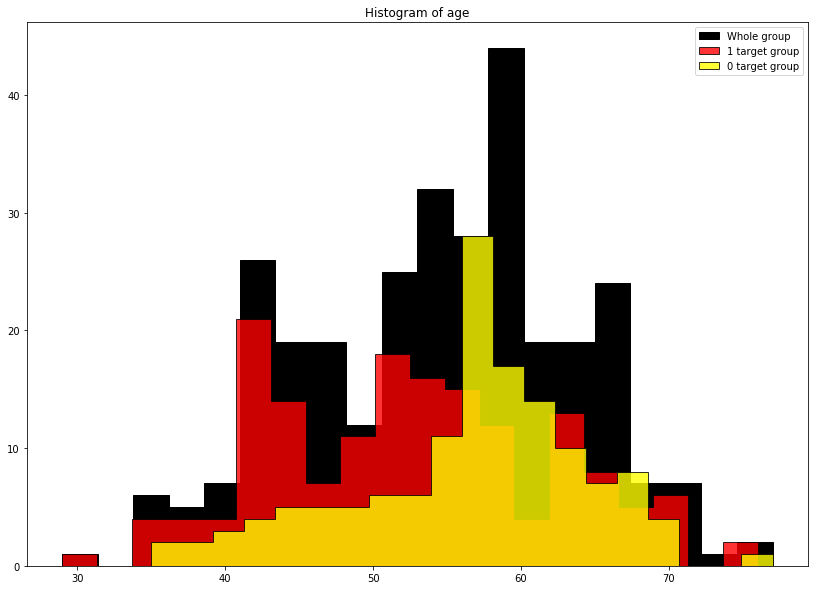

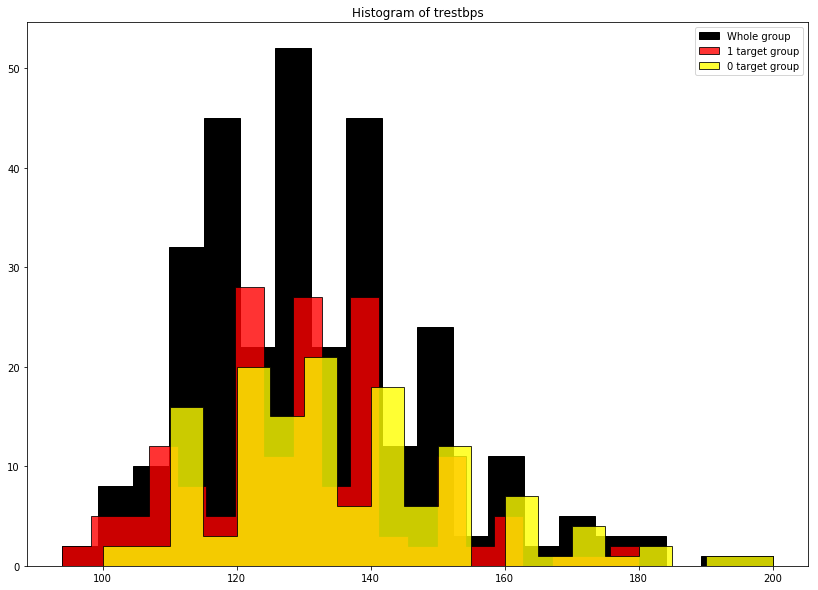

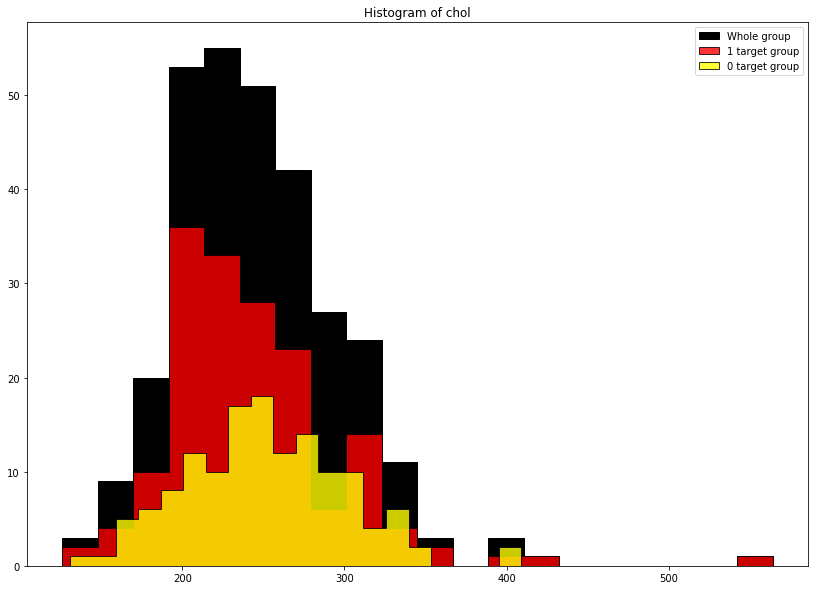

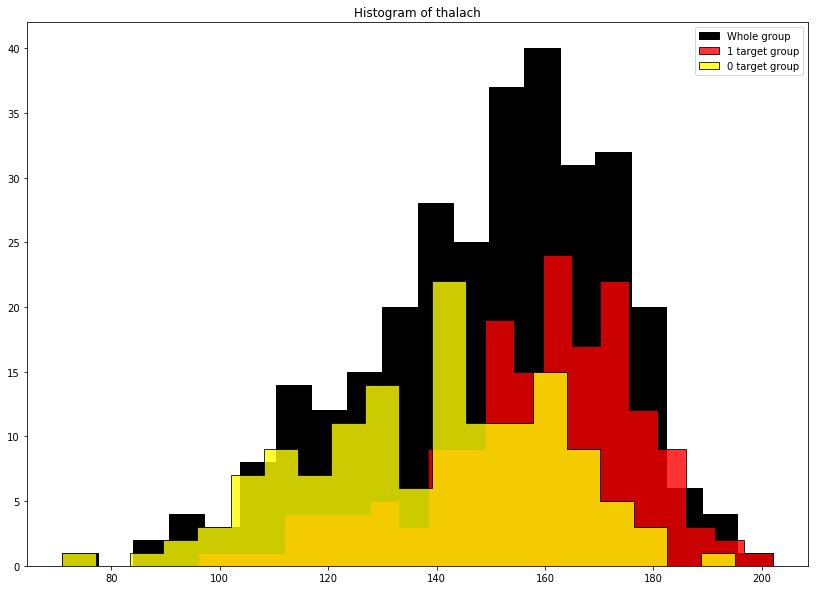

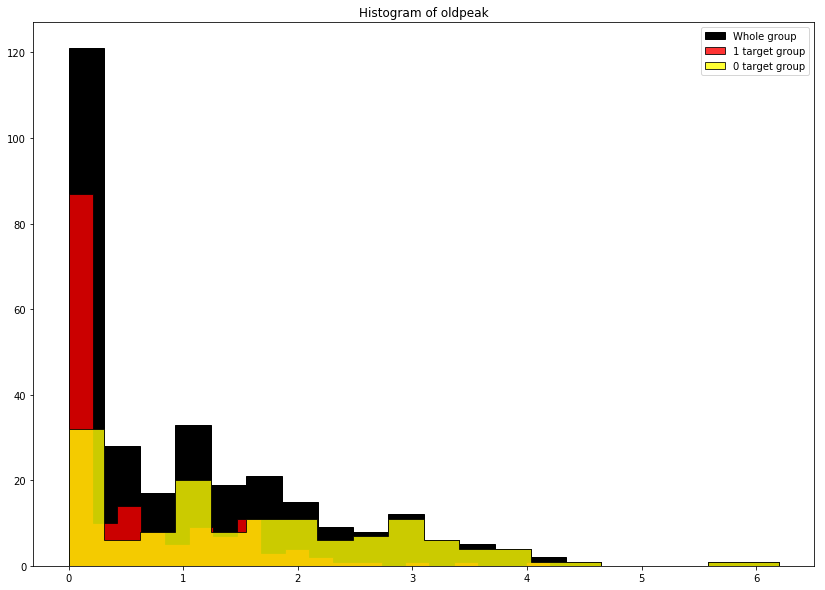

In [16]:
for n in num_cols:
    plot_hist(n)

Skewness: cp 0.4823
Skewness: restecg 0.1617
Skewness: slope -0.5058
Skewness: ca 1.3039
Skewness: thal -0.4744


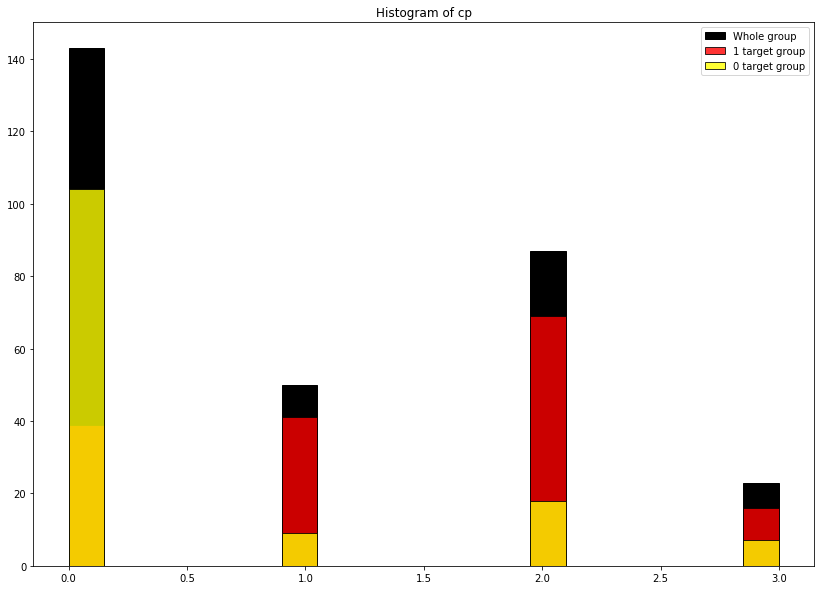

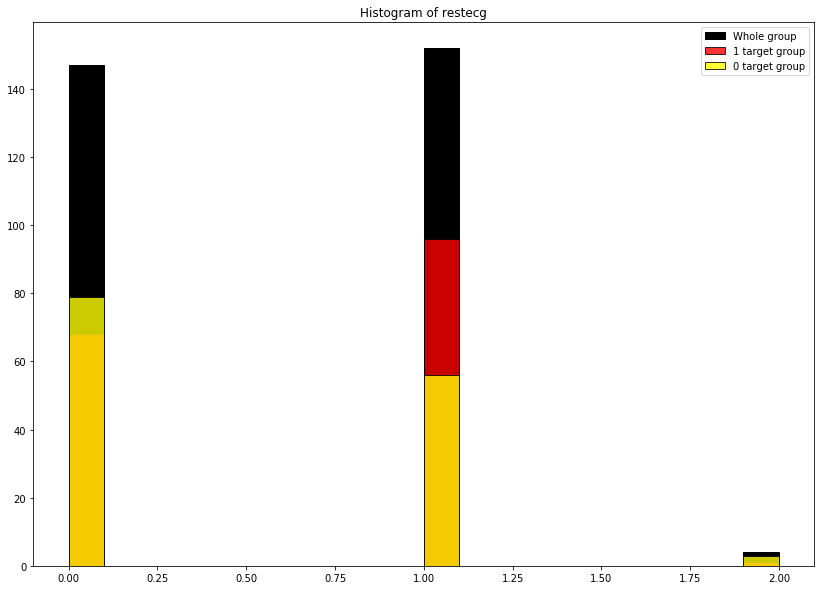

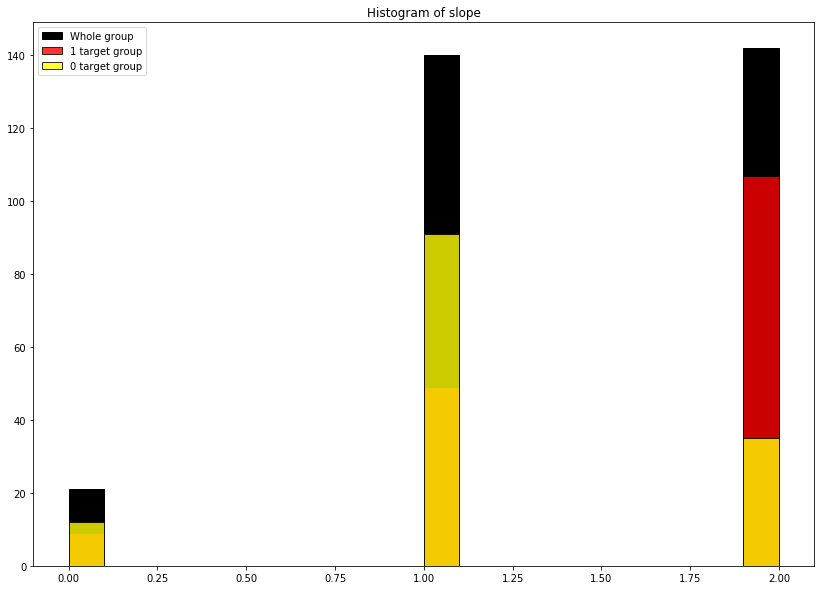

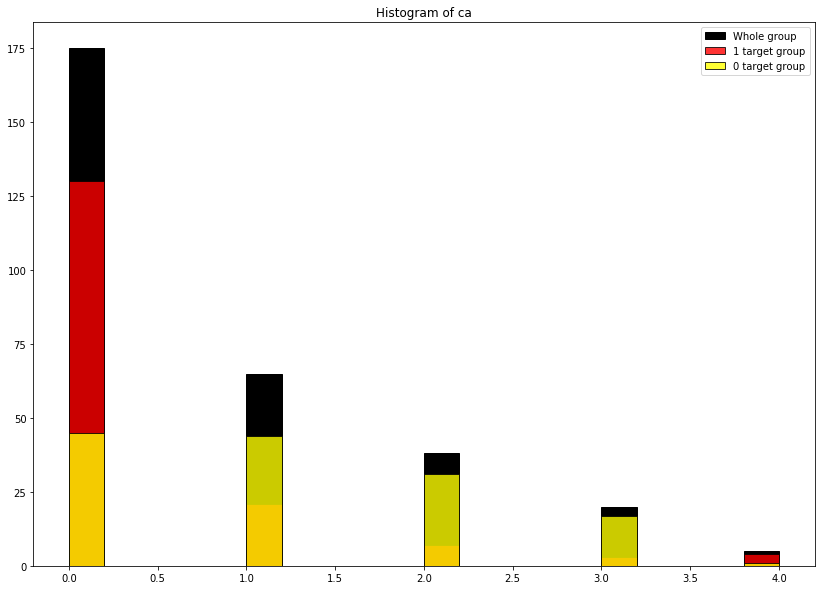

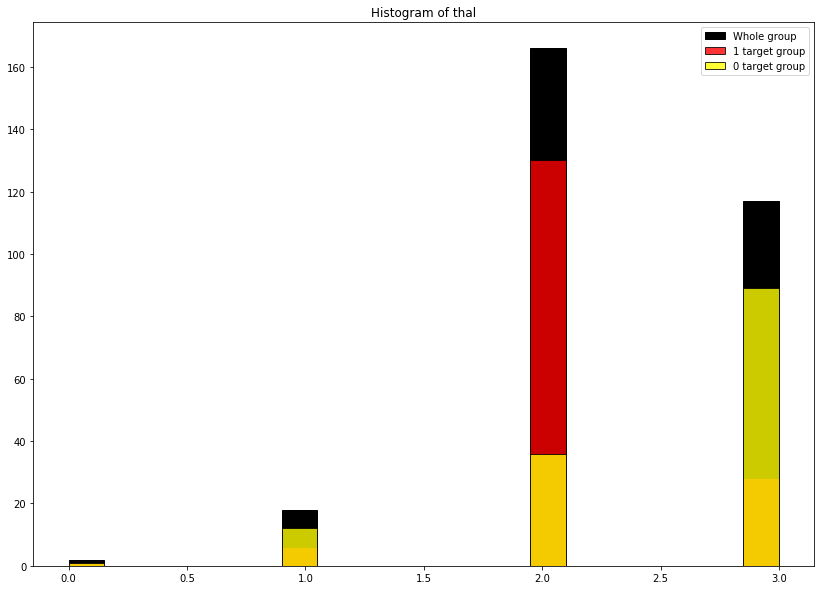

In [17]:
for o in old_columns:
    plot_hist(o)

**Modeling**

In [18]:
def prepare_data(test_size, scale=None, get_dummies=None, drop_first=None):
    # X and y
    y = df['target']
    X = df.drop(col_to_drop, axis=1)
    
    # dummies
    if get_dummies:
        X = pd.get_dummies(X, drop_first=drop_first)
        
    # TRAIN TEST
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y, test_size=test_size, random_state=1)
    # SCALING
    if scale:
        scaler = StandardScaler()
        X_TRAIN = scaler.fit_transform(X_TRAIN)
        X_TEST = scaler.fit_transform(X_TEST)
        
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

In [19]:
def model_perfomance(model, text, coef=None, importance=None):
    model.fit(X_TRAIN, Y_TRAIN)
    Y_PRED = model.predict(X_TEST)
    Y_PRED_PROBA = model.predict_proba(X_TEST)
    cnf = confusion_matrix(Y_TEST,Y_PRED)
    cnf = pd.DataFrame(cnf)
    acc = accuracy_score(Y_TEST, Y_PRED)
    rec = recall_score(Y_TEST, Y_PRED)
    prec = precision_score(Y_TEST, Y_PRED)
    roc = roc_auc_score(Y_TEST, Y_PRED_PROBA[:,1])
    print('Accuracy: ', accuracy_score(Y_TEST, Y_PRED))
    print('Recall: ', recall_score(Y_TEST, Y_PRED))
    print('Precision: ', precision_score(Y_TEST, Y_PRED))
    print('ROC AUC', roc)
    bar = pd.DataFrame(index=['Measure', 'Value'],
                      data=[['Accuracy', 'Recall', 'Precision'],[acc,rec,prec]])
    bar = bar.T
    plt.figure(figsize=(15,15))
    plt.suptitle(text, fontsize=18)
    plt.subplot(311)
    sns.heatmap(cnf.T, annot=True)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.subplot(312)
    sns.barplot(y=bar['Measure'], x=bar['Value'], edgecolor='black')
    if coef:
        coef = pd.DataFrame(columns=X_TRAIN.columns, data=model.coef_)
        print(model.coef_.shape)
        plt.subplot(313)
        sns.barplot(x=coef.T.index, y=coef.T[0])
        plt.ylabel('Coefficients')
        plt.xticks(rotation=90)
    if importance:
        #coef = pd.DataFrame(columns=X_TRAIN.columns, data=np.transpose(model.feature_importances_))
        print(np.transpose(model.feature_importances_).shape)
        plt.subplot(313)
        sns.barplot(x=X_TRAIN.columns,y=model.feature_importances_)
        plt.xticks(rotation=90)
    return model
        

In [20]:
def grid(estimator, params, cv):
    #data
    y = df['target']
    X = df.drop(col_to_drop, axis=1)
    # dummies
    X = pd.get_dummies(X, drop_first=True)

    cv = GridSearchCV(estimator=estimator, param_grid=params, cv=cv)
    cv.fit(X,y)
    #
    print(cv.best_params_)
    return cv.best_estimator_
    

In [21]:
def estimation():
    logit = LogisticRegression(max_iter=10000, solver='lbfgs', random_state=1)
    rf1 = RandomForestClassifier(random_state=1)

    params_l = {'C': np.linspace(0.1,1,10)}
    params_r = {'max_depth' : [2,3,4,5],
               'max_features' : [2, 3, 5],
               'n_estimators': [400,600,800]}

    model_logit = grid(logit, params_l, 3)
    model_rf = grid(rf1, params_r, 3)
    print('Logit model')
    logit_clf = model_perfomance(model_logit, 'Logistic regression', coef=True, importance=False)
    print('Random forest model')
    rf_clf = model_perfomance(model_rf, 'Random forest model', coef=False, importance=True)

**Model with categorical data**

{'C': 0.7000000000000001}
{'max_depth': 4, 'max_features': 2, 'n_estimators': 600}
Logit model
Accuracy:  0.84
Recall:  0.8518518518518519
Precision:  0.8518518518518519
ROC AUC 0.8989533011272142
(1, 22)
Random forest model
Accuracy:  0.8
Recall:  0.8148148148148148
Precision:  0.8148148148148148
ROC AUC 0.8824476650563607
(22,)


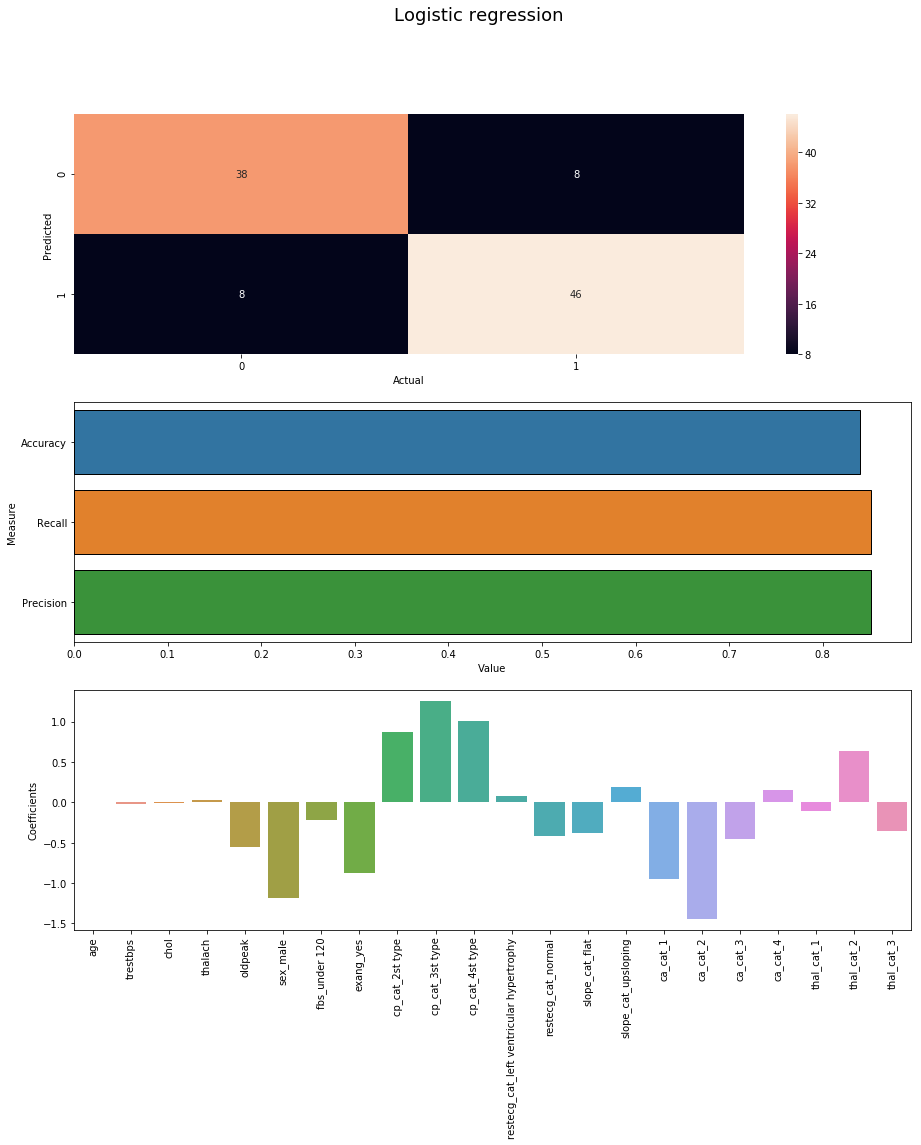

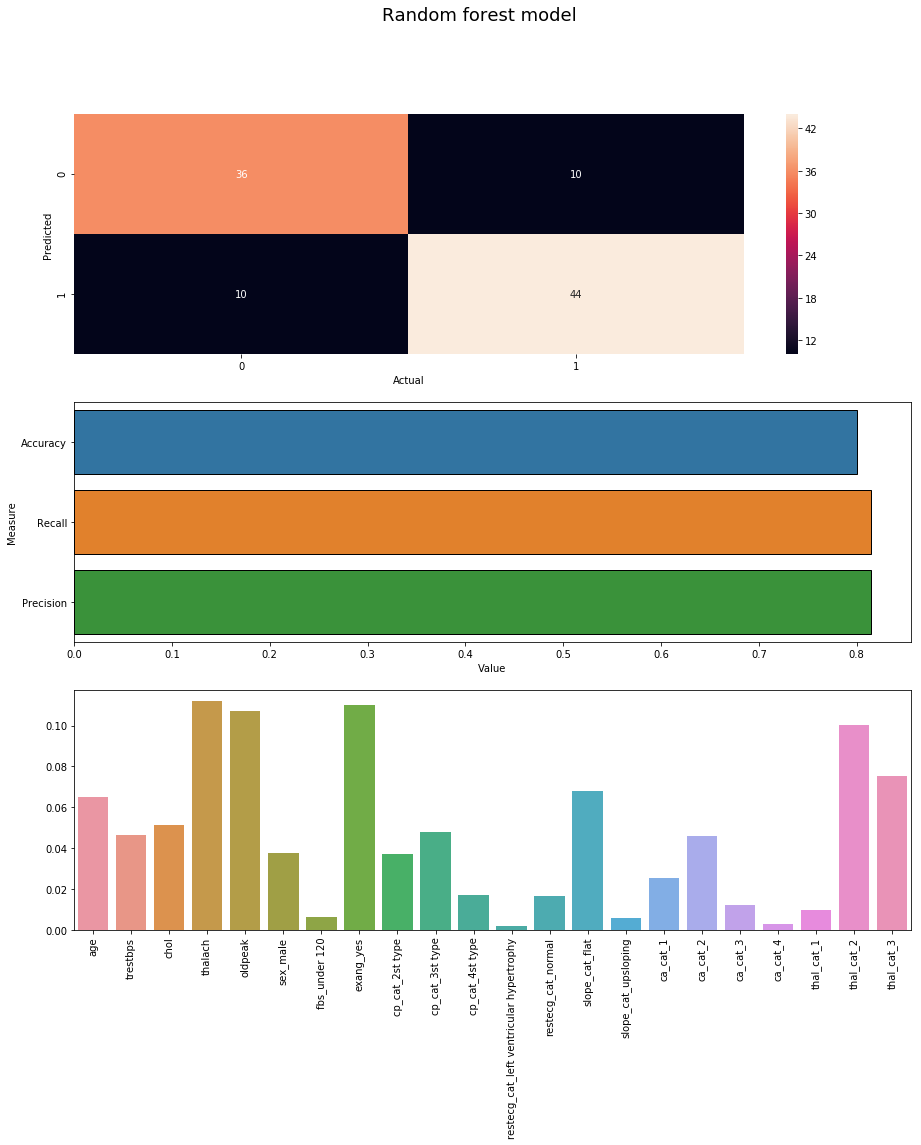

In [22]:
col_to_drop = ['target', 'cp', 'restecg','slope','ca', 'thal']
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = prepare_data(0.33, scale=False, get_dummies=True, drop_first=True)
estimation()

**Model with continous data**

{'C': 0.30000000000000004}
{'max_depth': 4, 'max_features': 3, 'n_estimators': 400}
Logit model
Accuracy:  0.78
Recall:  0.8518518518518519
Precision:  0.7666666666666667
ROC AUC 0.8784219001610305
(1, 13)
Random forest model
Accuracy:  0.79
Recall:  0.8333333333333334
Precision:  0.7894736842105263
ROC AUC 0.8695652173913043
(13,)


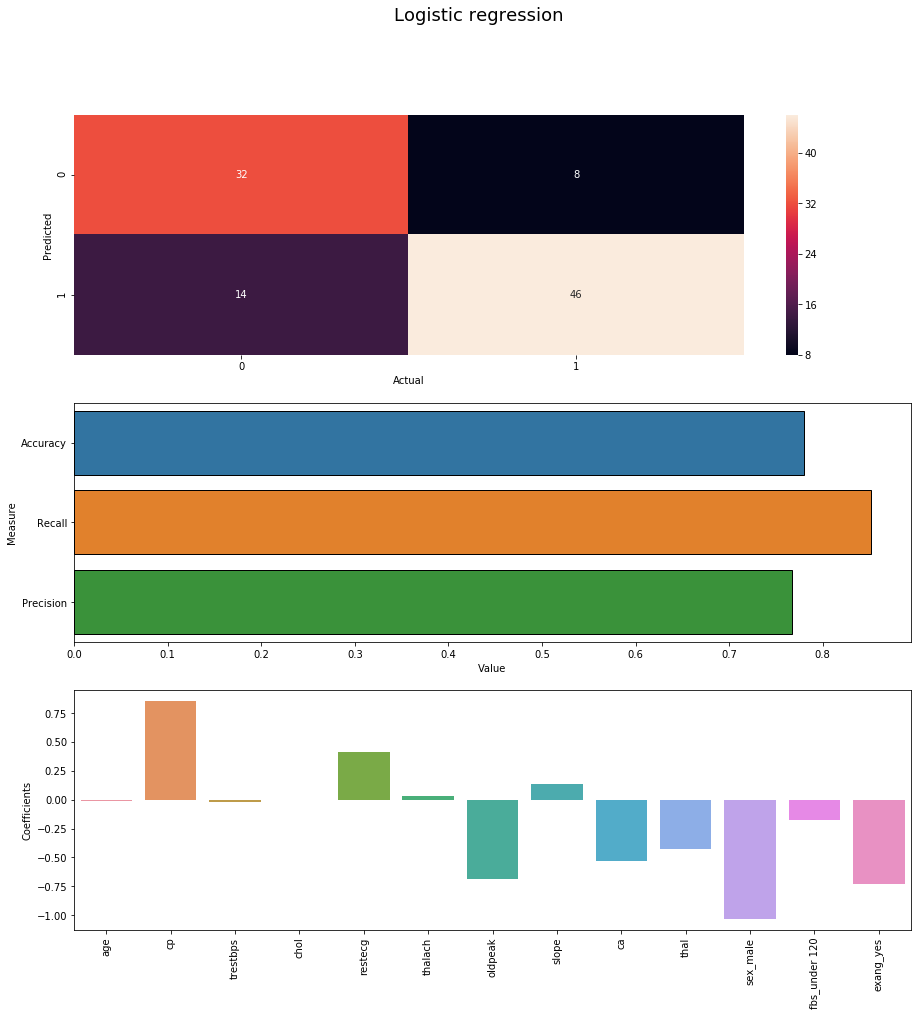

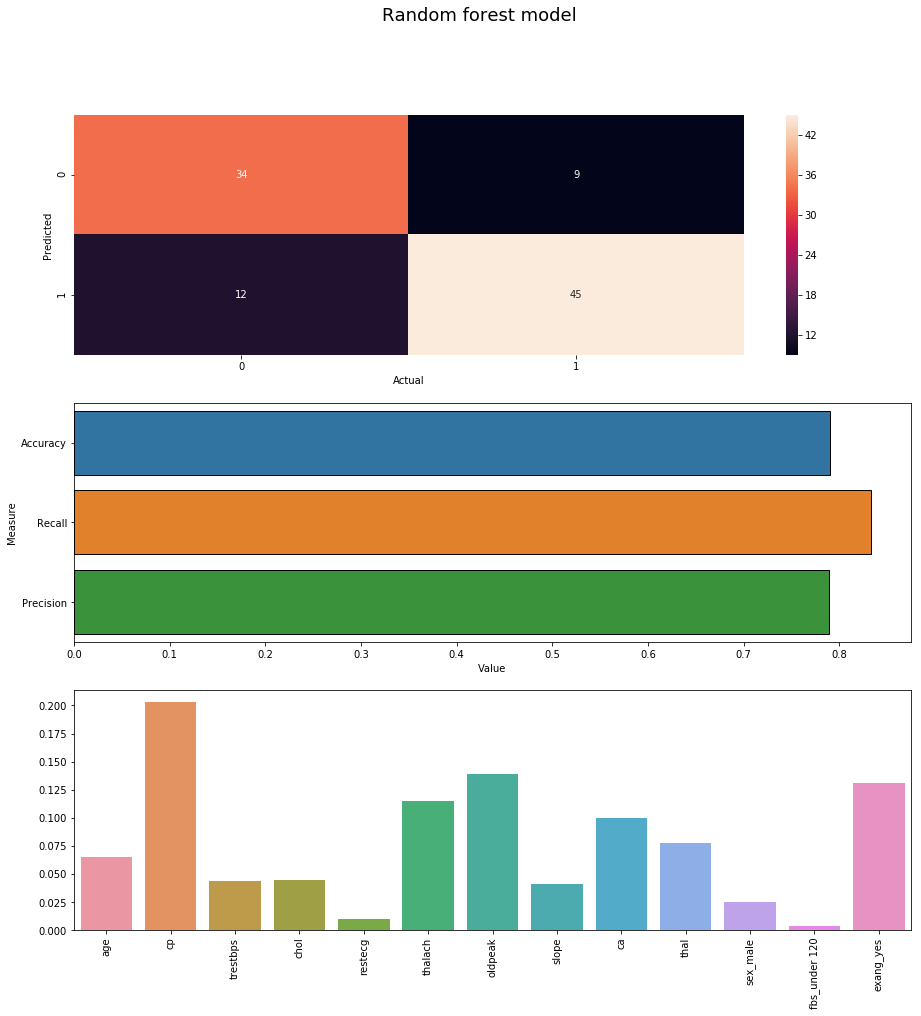

In [23]:
col_to_drop = ['target', 'cp_cat', 'restecg_cat','slope_cat','ca_cat', 'thal_cat']
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = prepare_data(0.33, scale=False, get_dummies=True, drop_first=True)
estimation()

My assumption from beggining of the kernel seems correct. Model with categorical data has better perfomance. One thing to remember is that I compared results on the same test set(I used constant random state on train-test split).